# Heteroskedastic fully and partially Bayesian neural nets

*Prepared by Maxim Ziatdinov (October 2024)*

We usually assume by default a constant observation noise across all inputs. However, this assumption doesn't always hold in real-world datasets which may exhibit input-dependent levels of noise. NeuroBayes offers heteroskedastic BNNs that can capture varying levels of noise in different regions of the data, allowing for more accurate uncertainty quantification.

Imports:

In [1]:
import sys
sys.path.append("..")

import neurobayes as nb

import numpy as np
import matplotlib.pyplot as plt

Define helper functions:

In [39]:
def toydata1d():

    x_start = 0
    x_stop = 4

    def f(x):
        return np.sin(3*(x-2)) + (x-2)**2

    return (x_start, x_stop), f

def noise_std(x):
    return 0.1 * np.exp(0.3 * x)

def measure(x, noise=True):
    y = toyfunc(x)
    if noise:
        y += np.random.randn(y.shape[0]) * noise_std(x)
    return y

Create toy dataset:

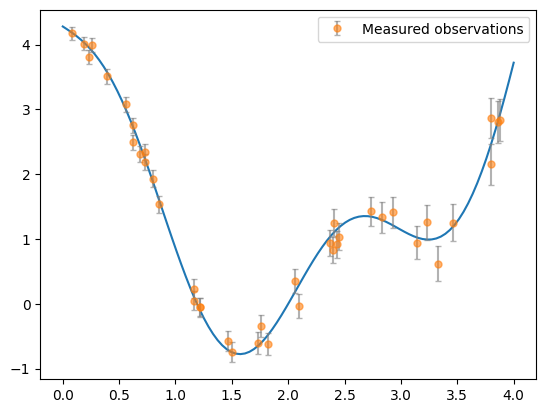

In [57]:
num_points = 40

(x_start, x_stop), toyfunc = toydata1d()

np.random.seed(42)

X_measured = np.random.uniform(x_start, x_stop, num_points)
y_measured = measure(X_measured)

X_domain = np.linspace(x_start, x_stop, 100)
y_true = measure(X_domain, noise=False)

plt.plot(X_domain, y_true)
plt.errorbar(X_measured, y_measured, yerr=noise_std(X_measured), fmt='o',
             markersize=5, ecolor='gray', capsize=2, label='Measured observations', alpha=0.6)
plt.legend()

First, train a fully Bayesian heteroskedastic NN:

In [ ]:
target_dim = 1
hidden_dims = [32, 16, 8]

architecture = nb.FlaxMLP2Head(hidden_dims, target_dim)

bnn = nb.HeteroskedasticBNN(architecture)
bnn.fit(X_measured, y_measured, num_warmup=1000, num_samples=1000)

sample: 100%|██████████| 2000/2000 [00:35<00:00, 56.49it/s, 1023 steps of size 1.21e-03. acc. prob=0.92]


Make prediction:

In [59]:
posterior_mean, posterior_var = bnn.predict(X_domain)

Plot results:

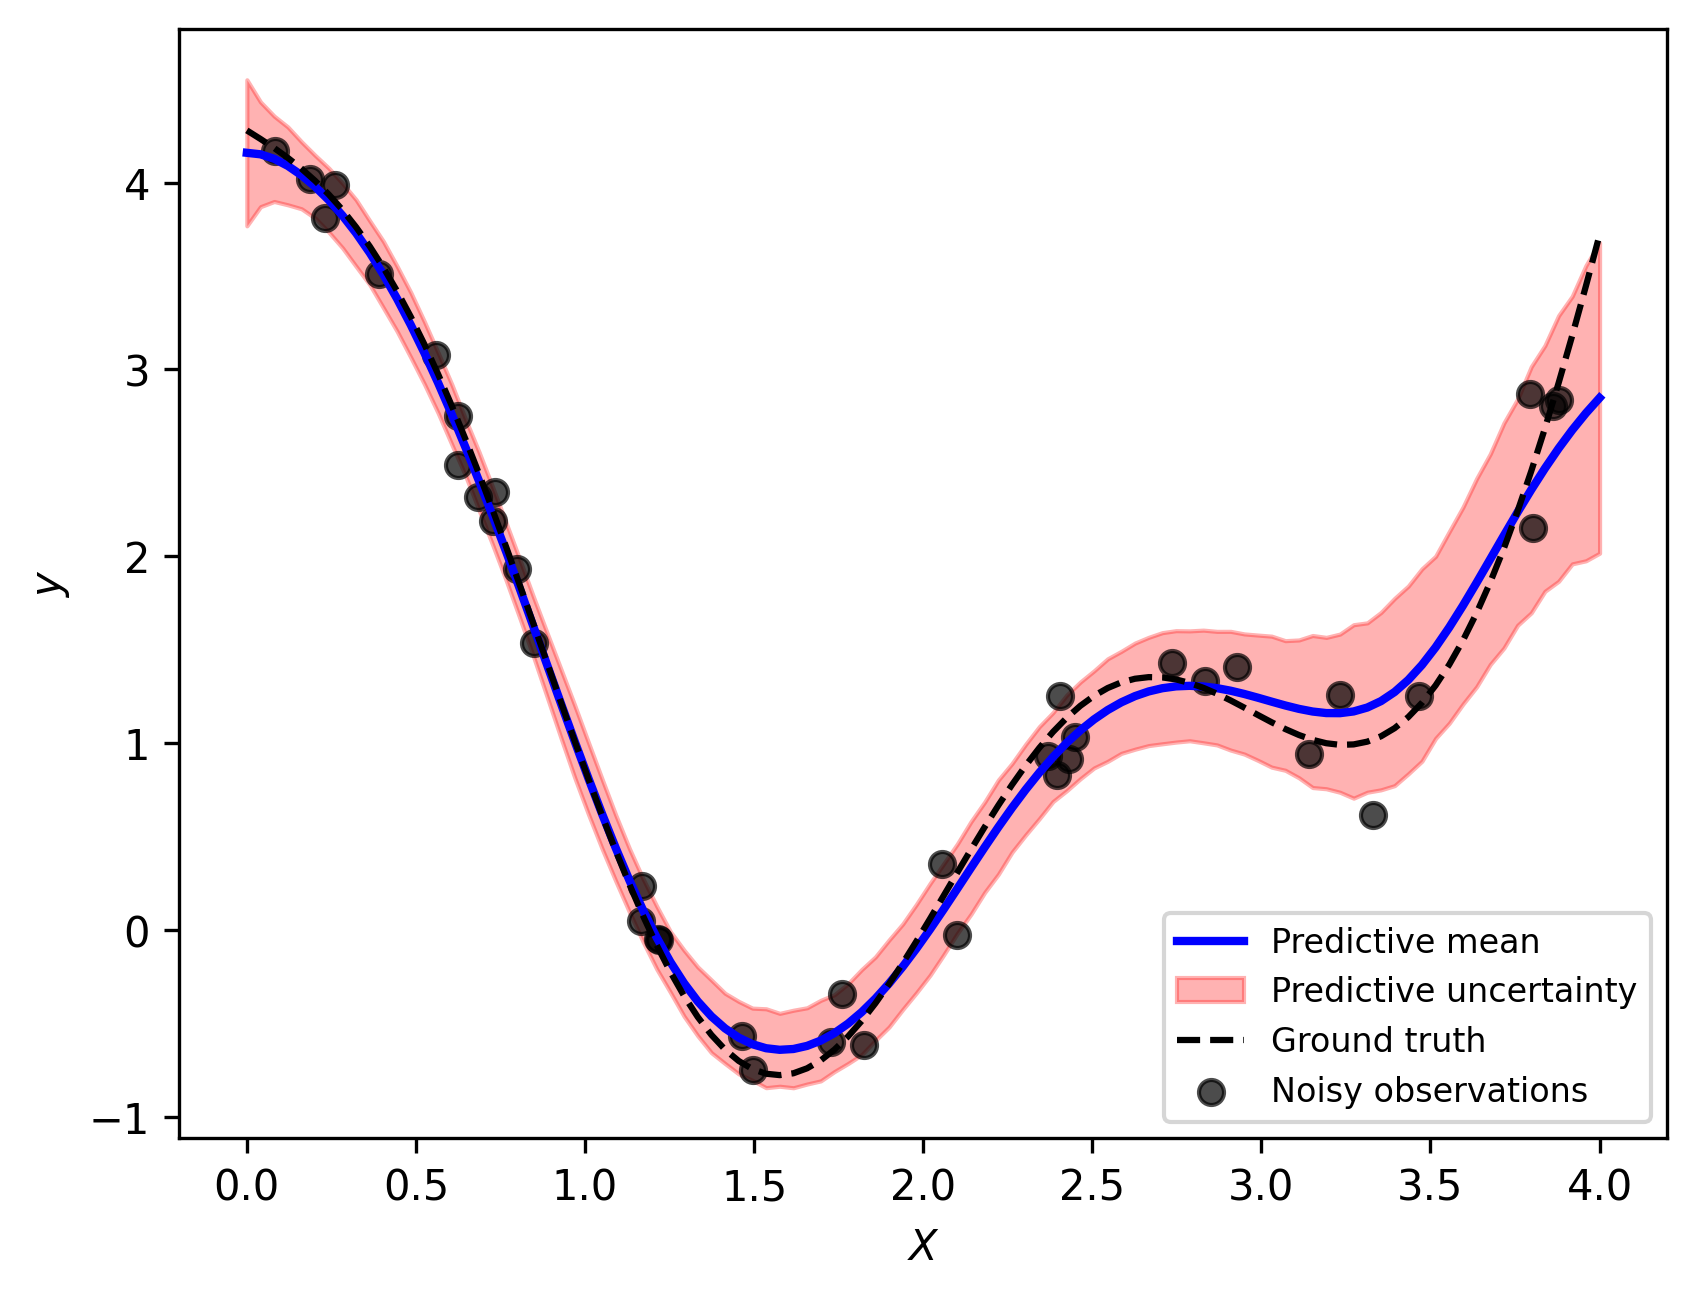

In [60]:
posterior_mean = posterior_mean.squeeze()
posterior_var = posterior_var.squeeze()

_, ax = plt.subplots(dpi=300)
ax.set_xlabel("$X$")
ax.set_ylabel("$y$")
ax.plot(X_domain, posterior_mean, lw=2.0,  c='blue', label='Predictive mean')
ax.fill_between(X_domain,
                posterior_mean - np.sqrt(posterior_var),
                posterior_mean + np.sqrt(posterior_var),
                color='r', alpha=0.3, label="Predictive uncertainty")
ax.plot(X_domain, y_true, '--', c='k', label='Ground truth')
ax.scatter(X_measured, y_measured, c='k', label="Noisy observations", alpha=0.7)
ax.legend(loc='best', fontsize=8)
plt.show()

We can also predict noise and compare it with actual noise in our data:

(0.0, 1.5)

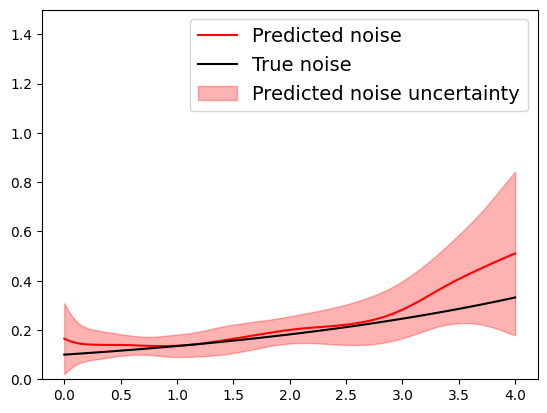

In [61]:
predicted_noise, predicted_noise_variance = bnn.predict_noise(X_domain)

predicted_noise = predicted_noise.squeeze()
predicted_noise_variance = predicted_noise_variance.squeeze()
plt.plot(X_domain, predicted_noise, color='r', label='Predicted noise')
plt.plot(X_domain, noise_std(X_domain), color='k', label='True noise')
plt.fill_between(
    X_domain,
    predicted_noise - np.sqrt(predicted_noise_variance),
    predicted_noise + np.sqrt(predicted_noise_variance),
    color='r', alpha=0.3, label="Predicted noise uncertainty")
plt.legend(fontsize=14)
plt.ylim(0, 1.5)

Now do the same using partially Bayesian heteroskedastic NN:

In [68]:
target_dim = 1
hidden_dims = [32, 16, 8, 8]

architecture = nb.FlaxMLP2Head(hidden_dims, target_dim)

pbnn = nb.HeteroskedasticPartialBNN(architecture, num_probabilistic_layers=2)
pbnn.fit(X_measured, y_measured, sgd_epochs=5000, sgd_lr=5e-3, num_warmup=1000, num_samples=1000)

Training deterministic NN...


Training Progress: 100%|██████████| 5000/5000 [00:03<00:00, 1333.34it/s, Epoch 5000/5000, Avg Loss: -0.9511]


Training partially Bayesian NN


sample: 100%|██████████| 2000/2000 [00:13<00:00, 144.30it/s, 1023 steps of size 2.37e-03. acc. prob=0.90]


In [69]:
posterior_mean, posterior_var = pbnn.predict(X_domain)

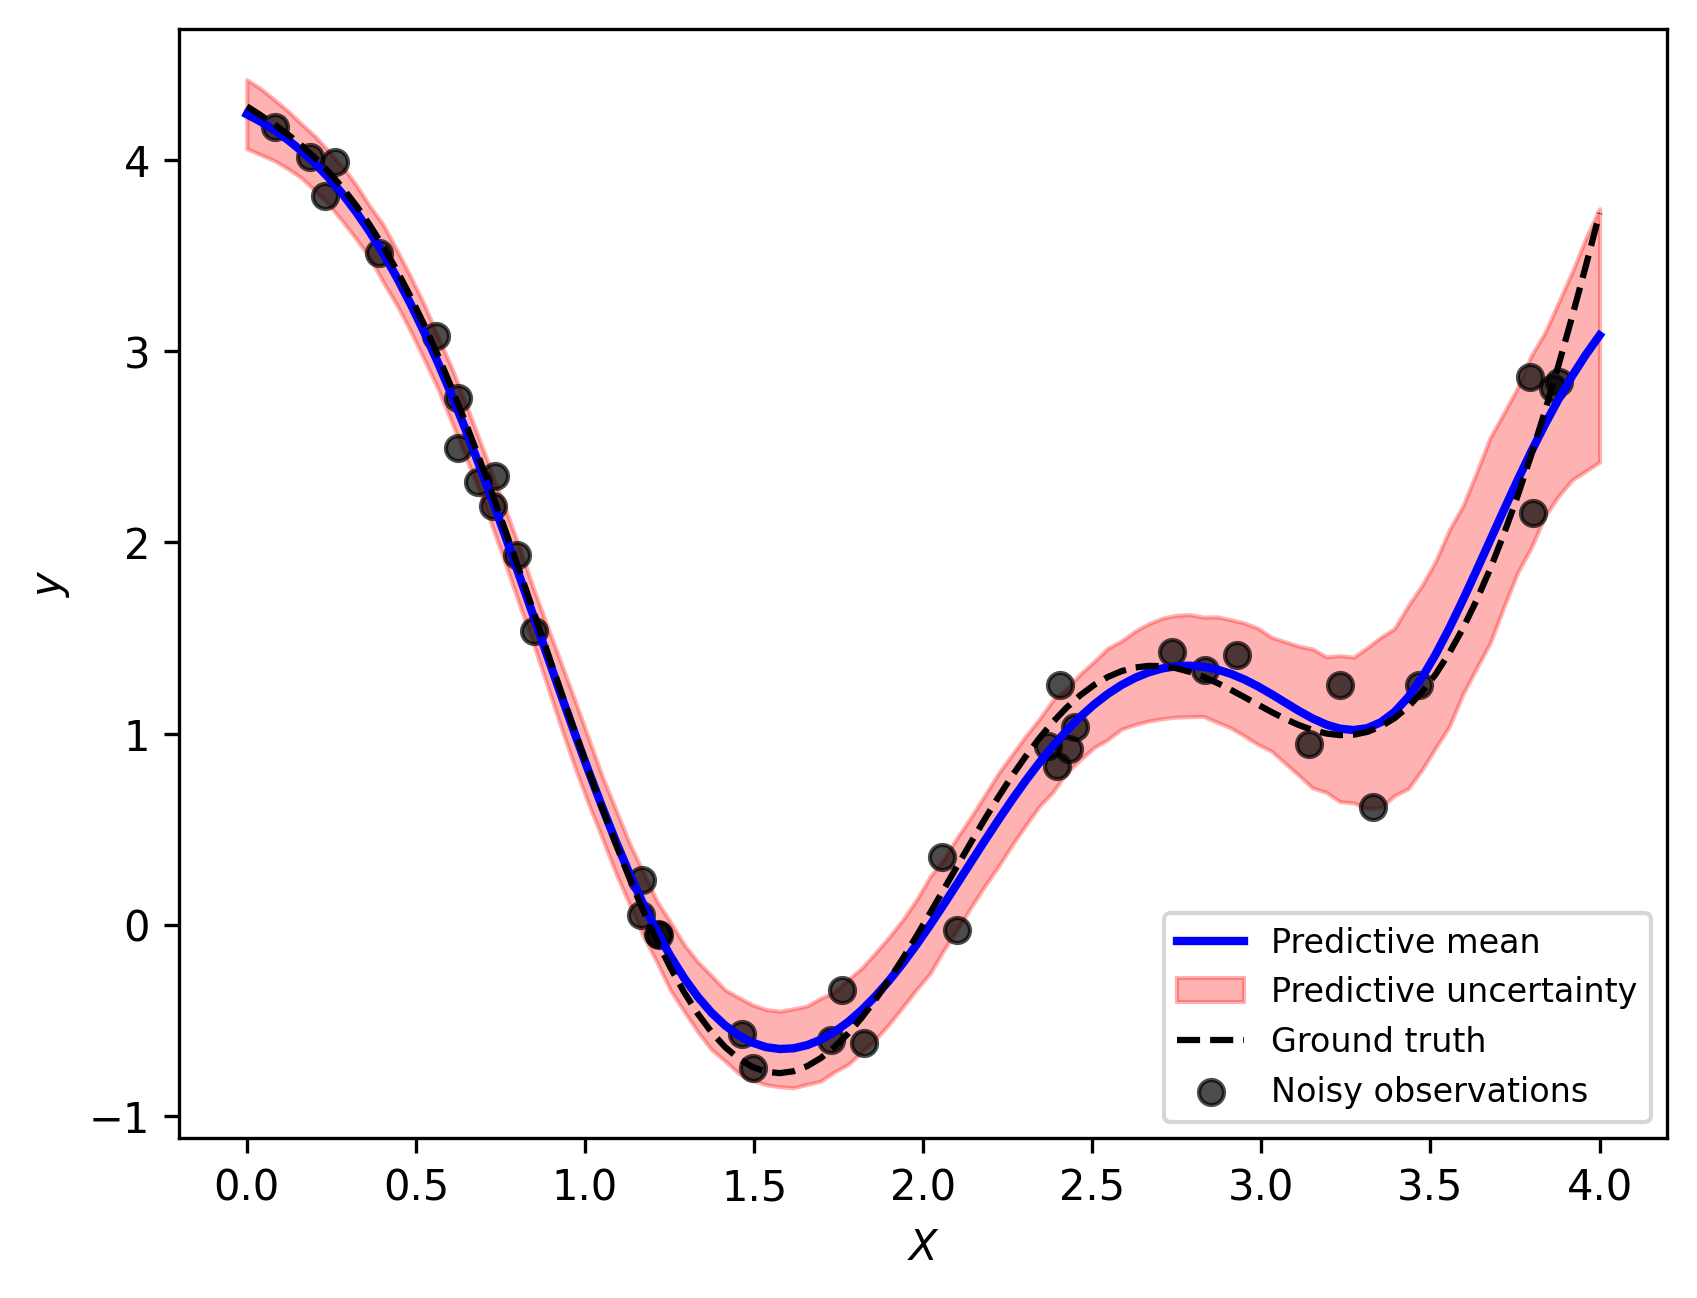

In [70]:
posterior_mean = posterior_mean.squeeze()
posterior_var = posterior_var.squeeze()

_, ax = plt.subplots(dpi=300)
ax.set_xlabel("$X$")
ax.set_ylabel("$y$")
ax.plot(X_domain, posterior_mean, lw=2.0,  c='blue', label='Predictive mean')
ax.fill_between(X_domain,
                posterior_mean - np.sqrt(posterior_var),
                posterior_mean + np.sqrt(posterior_var),
                color='r', alpha=0.3, label="Predictive uncertainty")
ax.plot(X_domain, y_true, '--', c='k', label='Ground truth')
ax.scatter(X_measured, y_measured, c='k', label="Noisy observations", alpha=0.7)
ax.legend(loc='best', fontsize=8)
plt.show()

(0.0, 1.5)

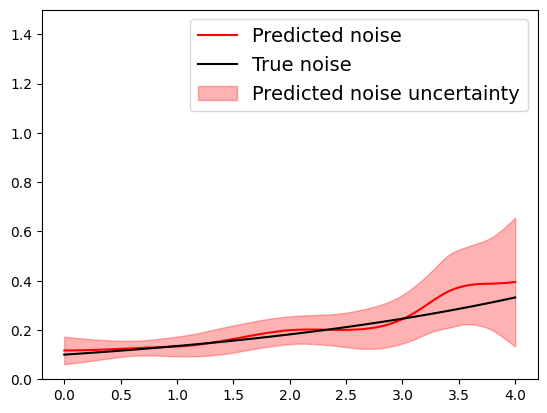

In [71]:
predicted_noise, predicted_noise_variance = pbnn.predict_noise(X_domain)

predicted_noise = predicted_noise.squeeze()
predicted_noise_variance = predicted_noise_variance.squeeze()
plt.plot(X_domain, predicted_noise, color='r', label='Predicted noise')
plt.plot(X_domain, noise_std(X_domain), color='k', label='True noise')
plt.fill_between(
    X_domain,
    predicted_noise - np.sqrt(predicted_noise_variance),
    predicted_noise + np.sqrt(predicted_noise_variance),
    color='r', alpha=0.3, label="Predicted noise uncertainty")
plt.legend(fontsize=14)
plt.ylim(0, 1.5)

We can see that we were able to achive comparable results at a fraction of the computational time.